In [1]:
!pip install spflow -q
!pip install matplotlib -q  
!pip install numpy -q

# Overview
- Network Polynomials
- Sum Product Networks 
    - Overview
    - Valid or not
    - Inference
        - Probabilities
        - Marginals
        - Conditional Probabilities
        - Sampling
        - Most Probable Explanation (MPE)
    - Summary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Set numpy precision
np.set_printoptions(precision=4)

## Network Polynomials and Joint Distributions

We start with an example for a joint distribution table. Our simple example has four random variables $X = (X_1, X_2, X_3, X_4)$ each of binary scope ($X_i \in \{0, 1\}$) with the following probabilities.

| $X_1$ | $X_2$ | $X_3$ | $X_4$ | P(X) |
|---|---|---|---|------------------|
| 0 | 0 | 0 | 0 | 0.1  |
| 0 | 0 | 0 | 1 | 0.0  |
| 0 | 0 | 1 | 0 | 0.0  |
| 0 | 0 | 1 | 1 | 0.2  |
| 0 | 1 | 0 | 0 | 0.25 |
| 0 | 1 | 0 | 1 | 0.05 |
| 0 | 1 | 1 | 0 | 0.0  |
| 0 | 1 | 1 | 1 | 0.0  |
| 1 | 0 | 0 | 0 | 0.0  |
| 1 | 0 | 0 | 1 | 0.0  |
| 1 | 0 | 1 | 0 | 0.0  |
| 1 | 0 | 1 | 1 | 0.0  |
| 1 | 1 | 0 | 0 | 0.1  |
| 1 | 1 | 0 | 1 | 0.05 |
| 1 | 1 | 1 | 0 | 0.05 |
| 1 | 1 | 1 | 1 | 0.2  |

Given the partition table, we can construct a network polynomial.

### Exercise 1
Construct the network polynomial (in a python function).

### Exercise 2
Compute the probabilities of the following random variable instantiations by using the network polynomial 

| $X_1$ | $X_2$ | $X_3$ | $X_4$ | 
|---|---|---|---|
| 1 | 1 | 1 | 1 |
| 1 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 |
| 0 | 0 | 0 | 0 |


### Exercise 3
Use the network polynomial to compute the marginal distribution $P(X_1 = 1, X_2 = 1, X_3 = 1)$. This means we have no information given on $X_4$. How can we use the network polynomial to do so?

### Exercise 4
What happens when we marginalize over all variables, meaning we insert ($x_1, \overline{x}_1, x_2, \overline{x}_2, x_3, \overline{x}_3, x_4, \overline{x}_4) = (1, 1, 1, 1, 1, 1, 1, 1)$ into the network polynomial?

# Sum Product Networks

Sum Product Networks are (deep) probabilistic models that encode a joint probability distribution (JPD) over a set of random variables. SPNs allow different inference types in an efficient way and can be trained by gradient based methods, expectation maximization. Even structure learning algorithms exist that make it obsolete to specify the network structure a priori.

SPNs factorize the network polynomial of the underlying distribution and enable efficient computations of multiple queries possible: 
* **Probabilities/Likelihoods**
* **Magignals** 
* **Conditional Probabilities**
* approx. **Most Probable Explanation (MPE)**
* **Sampling**.

Every of these operations can be done in linear time of the network, where the size of the network is determined by the number of edges.

In the following, we will build an SPN in spflow and examine different inference types.

![alt text](SPN1.png "SPN1")

## When is an SPN valid?
In order to be valid, meaning the SPN represents a correct joint probability distribution over its variables, it is sufficient to check two properties:

#### At Sum Nodes
Each child of the sum node has to have the same scope!

#### At Product Nodes
Each child of the product node has to have a disjoint scope of the other childs.

The scope of leafes are defined as follows:
\begin{align}
sc(X_i) &= \{ X_i \} \\
sc(\overline{X}_i) &= \{ X_i \}
\end{align}

## SPFlow

SPFlow is a Sum Product Network framework in python: https://github.com/SPFlow/SPFlow.git.
If you want to get in touch with SPNs, you might try it out, since it offer multiple inference mechanisms, as well as an implementation of the structure learning algorithm LearnSPN. Let's get started by building the same network, we already investigated. 

## Building an SPN in spflow


![alt text](SPN1.png "SPN1")

In [7]:
#import spflow
import spn
from spn.structure.leaves.parametric.Parametric import Bernoulli
from spn.structure.Base import Product, Sum, assign_ids, rebuild_scopes_bottom_up
from spn.algorithms.Inference import log_likelihood, likelihood
from spn.io.Graphics import plot_spn
from numpy.random.mtrand import RandomState
from spn.algorithms.Sampling import sample_instances
from spn.algorithms.MPE import mpe

In [8]:
X1 = Bernoulli(p=1.0, scope=0)
X1_ = Bernoulli(p=0.0, scope=0)

X2 = Bernoulli(p=1.0, scope=1)
X2_ = Bernoulli(p=0.0, scope=1)

X3 = Bernoulli(p=1.0, scope=2)
X3_ = Bernoulli(p=0.0, scope=2)

# Here you can change the weights if you like and see what happens.
sum1 = Sum(children=[X2, X2_], weights=[0.3, 0.7])
sum2 = Sum(children=[X2, X2_], weights=[0.5, 0.5])
sum3 = Sum(children=[X3, X3_], weights=[0.6, 0.4])
sum4 = Sum(children=[X3, X3_], weights=[0.9, 0.1])

Prod1 = Product(children=[X1, sum1, sum3])
Prod2 = Product(children=[X1_, sum2, sum4])

# Here you can change the weights if you like and see what happens.
SPN = Sum(children=[Prod1, Prod2], weights=[0.8, 0.2])

# Call these to reorganize the indicies internally.
assign_ids(SPN)
rebuild_scopes_bottom_up(SPN)

SumNode_0

## Plotting the SPN

/home/tfleck/.virtualenvs/2018-ml_uebung/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


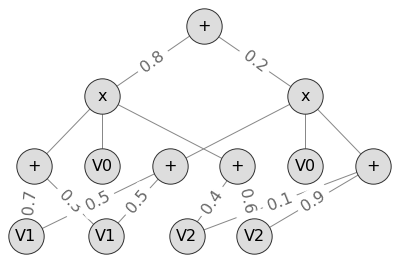

In [9]:
plot_spn(SPN, 'SPN.png')

As a next step, we want to do the same computation as before, namely computing the probabilities the SPN represents:

## Computing Probabilities 

In [10]:
input_data = np.array([0, 0, 0]).reshape(1, 3)
print("P(X1 = 0, X2 = 0, X3 = 0) = " + str(likelihood(SPN, input_data)))

P(X1 = 0, X2 = 0, X3 = 0) = [[0.01]]


### Exercise 5
Compute the full joint probability distribution table by calling the likelihood function of spflow. In other words: Compute the probability for each combination of variable assignments on $X_1, X_2$ and $X_3$

## Marginalization of Variables

Now let's examine how marginal probabilities can be computed in the spflow network. While we have to set "ones" for every unknown indicator in a classical SPN, things are slightly different in spflow: Here we have to give "np.nan" as a value for the referring random variable and spflow takes care of the rest for us. Let's try it!

In [12]:
data = np.array([1, np.nan, np.nan]).reshape(-1, 3)
print('P(X1 = 1) = {}'.format(likelihood(SPN, data)))

P(X1 = 1) = [[0.8]]


As we see, the marginal probability $P(X_1 = 1)$ equals the previous probability computed by the network polynomial or the joint distribution table.

spflow can compute multiple queries of this type:

In [13]:
# Generate a numpy data array form a given list
data = np.array([1, np.nan, np.nan, 
                 0, np.nan, np.nan, 
                 np.nan, 0, np.nan, 
                 np.nan, 1, np.nan]).reshape(-1, 3)
print("input data:")
print(data)
print()

print("Marginal Probabilities:")
res = likelihood(SPN, data)

print('P(X1 = 1) = {}'.format(res[0]))
print('P(X1 = 0) = {}'.format(res[1]))
print('P(X2 = 0) = {}'.format(res[2]))
print('P(X2 = 1) = {}'.format(res[3]))

input data:
[[ 1. nan nan]
 [ 0. nan nan]
 [nan  0. nan]
 [nan  1. nan]]

Marginal Probabilities:
P(X1 = 1) = [0.8]
P(X1 = 0) = [0.2]
P(X2 = 0) = [0.66]
P(X2 = 1) = [0.34]


## Computing Conditional Probabilities

Assume that we know that $X_1 = 1$. Then we might query for the probability of $X_2 = 1, X_3 = 0$, given the fact that $X_1 = 1$ holds. Therefore we want to compute the conditional probability:

\begin{align}
P(X_2 = 1, X_3 = 0 \mid X_1 = 1)
\end{align}

This query can be done by using the definition of conditional probabilities:
\begin{align}
P(X = x \mid Y = y) = \frac{P(X = x, Y = y)}{P(Y = y)} 
\end{align}

In our context this means:
\begin{align}
P(X_2 = 1, X_3 = 0 \mid X_1 = 1) = \frac{P(X_1 = 1, X_2 = 1, X_3 = 0)}{P(X_2 = 1, X_3 = 0)} 
\end{align}


Thus we can compute P(X_2 = 1, X_3 = 0) in an upward pass through the network while marginalizing out $X_1$ (summing all possible instantiations of $X_1$), then proceed by computing $P(X_1 = 1, X_2 = 1, X_3 = 0)$ as a sinlge upward pass and then divide the gained probabilities. 

In [14]:
# Input for P(X1 = 1, X2 = 1, X3 = 0)
input_data = np.array([1, 1, 0]).reshape(1, 3)

# Input for P(X2 = 1, X3 = 0)
input_data2 = np.array([np.nan, 1, 0]).reshape(1, 3)

p_xy = likelihood(SPN, input_data)
p_y = likelihood(SPN, input_data2)

print(p_xy / p_y)

[[0.9057]]


## Sampling from the SPN

For a fixed SPN, we can also generate samples from the distribution the SPN represents. This is the reason why SPNs are called "Generative Models". There exist many other types of generative models and there is major interest in such models, since they are promising for tasks as image completion or similar tasks.

In [15]:
# number if samples
N = 10000

data_empty = np.array([ np.nan, np.nan, np.nan ] * N).reshape(-1, 3)

# Generate 
samples = sample_instances(SPN, data_empty, RandomState(0))

print(samples)

[[1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 ...
 [1. 0. 1.]
 [1. 1. 1.]
 [1. 0. 1.]]


Let's check if the empiric occurences match the probabilities the SPN computes. If we count all samples that have $X_1 = 1$ in them, then we should sum to 0.8, since it is the marginal distribution of the SPN!

In [16]:
count_ones = 0
count_zeros = 0
for s in samples:
    if np.isclose(s[0], 1.0):
        count_ones = count_ones + 1
    elif np.isclose(s[0], 0.0):
        count_zeros = count_zeros + 1
    else:
        # Should never happen!
        print("Error!")
        print(s)
        print()
        
total_count = count_ones + count_zeros
print("relative occurence for X1 = 1:  " + str(count_ones / total_count))
print("relative occurence for X1 = 0:  " + str(count_zeros / total_count))

relative occurence for X1 = 1:  0.8019
relative occurence for X1 = 0:  0.1981


As expected, the relative occurences of the variables match the marginal distribution of the SPN. If we just count the occurences of a single variable constellation or instantiation, e.g. $(X_1, X_2, X_3) = (1, 1, 1)$, then we should get the probability that the SPN computes:

In [17]:
count = 0
count_other = 0
for s in samples:
    if np.array_equal(s, np.array([1, 1, 1]).reshape(3,)):
        count = count + 1
    else:
        count_other = count_other + 1
        
total_count = count + count_other

print("relative occurence for X = (1, 1, 1):  " + str(count / total_count))
print("relative occurence for other X:        " + str(count_other / total_count))

relative occurence for X = (1, 1, 1):  0.1432
relative occurence for other X:        0.8568


So the value 0.1432 is approximately $P(X_1 = 1, X_2 = 1, X_3 = 1) = 1.44$, which fits our expectations. 

## Most Probable Explanation (MPE)

Let's try the Most Probable Explanation (MPE) Inference in our network. If we set $X_1 = 1$, then we should be able to complete $X2$ and $X3$ with MPE inference, as explained in the spn lecture. The MPE algorithm in SPNs does the following:

1. Replace all sums with max nodes. The weights are kept!
2. Compute an upward pass where unknown variables (in this case $X_2$ and $X_3$) are marginalize out
3. Do a backward pass and on eahc max node chose the child with the highest upward value. On Products, go down to every child!

If the SPN is valid, then this leads to a variable assignment which is not ambiguous and therefore to a valid "explanation" of the observed data.

In [18]:
data = np.array([1.0, np.nan, np.nan]).reshape(-1, 3)
print("Input data:")
print(data)
print()

# Perform MPE Inference.
completed = mpe(SPN, data)

print("Completed data")
print(completed)

Input data:
[[ 1. nan nan]]

Completed data
[[1. 0. 1.]]


So the most likely explanation when we make the observation $X_1 = 1$ is that the unonserved variables $X_2, X_3$
have the values $(X_2, X_3) = (0, 1)$. In this case this is the correct answer, since probability of the assignment $(X_1, X_2, X_3) = (1, 0, 1)$ equals $P(X_1 = 1, X_2 = 0, X_3 = 1) = 0.336$, which is the highest probability value when we set $X_1$ as fixed. It is even the highest probability in the computed distribution table.

### Excersice 6 
What is the most probable explanation for $X_2 = 0, X_3 = 1$

spflow offers a lot more than you have seen in this exercises. For instance an implementation of the structure learn algorithm LeanrSPN is included as well, which is quite easy to use in simple scenarios. Additional information here:
https://github.com/SPFlow/SPFlow

# Summary
Sum Product Networks provide:
- A fully probabilistic learning and inference model
- Efficient inference algorithms
    - Computation of probabilities
    - Computation of conditional probabilities
    - Computation of marginal probabilities
    - Approximate most probable explanation (MPE)
    - Sampling 
- Parameter Learning
    - Expectation Maximization
    - Gradient Descent, Hard Gradient Descent
        - Generative vs. Discriminative
- Structure Learning 
    - Greedy Cluster and Split algorithm 